# Exploring broadband hydrophone data: Part 2

- Take a closer look at the broadband blips that occur every 2-ish seconds, and try to come up with ways to work around those (assuming they're unwanted signals, possible mechanical or electrical).
- Explore scikit-image ridge detection as a possible way to determine , at least very broadly, if a particular spectrogram contains marine mammal vocalizations or other features of interest. 

In [123]:
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
import pandas as pd
import miniseed_tools as mst
from scipy import signal
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import hvplot.xarray

Load the lookup data file (created using ooi_crawler.py)

In [124]:
path_to_df = '../ooi_data/ooi_lookup.pkl'
df = pd.read_pickle(path_to_df)
df.tail()

,filepath,filename,starttime
350571,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2020-12-08T02:50:00.000015.mseed,2020-12-08 02:50:00.000015
350572,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2020-12-08T02:55:00.000000.mseed,2020-12-08 02:55:00.000000
350573,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2020-12-08T03:00:00.000000.mseed,2020-12-08 03:00:00.000000
350574,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2020-12-08T03:05:00.000015.mseed,2020-12-08 03:05:00.000015
350575,https://rawdata.oceanobservatories.org/files/R...,OO-AXVM1--YDH-2020-12-08T03:10:00.000015.mseed,2020-12-08 03:10:00.000015


Load a specific data file and request decimation

In [125]:
dat, fs, stime, etime = mst.load_mseed(df.iloc[350570],decimation_factor=16)
print('Sample rate is: ' + str(fs))
print('Start time of the file: ' + str(stime))
print('End time of file: ' + str(etime))

Sample rate is: 4000.0
Start time of the file: 2020-12-08T02:45:00.000015Z
End time of file: 2020-12-08T02:50:00.000765Z


Construct a spectrogram for this data

In [127]:
# Set spectrogram parameters
segment_length_seconds = 0.1
noverlap_percent = 20

# convert to n samples for use with spectrogram function
nperseg = int(segment_length_seconds * fs)
noverlap = int(nperseg * noverlap_percent/100)

# f, t, Sxx = signal.spectrogram(dat, fs, nperseg = nperseg, noverlap = noverlap)
f, t, Sxx = signal.spectrogram(dat, fs)

Sxarray = xr.DataArray(np.log10(Sxx), 
                       dims=('frequency', 'time'),
                       coords={'frequency':f, 'time':t})

# Detrend - axis 1
Sx_norm0 = Sxarray - Sxarray.mean(axis=1)

Plot the spectrogram along with the ridge detection output

Text(0, 0.5, 'Frequency (Hz)')

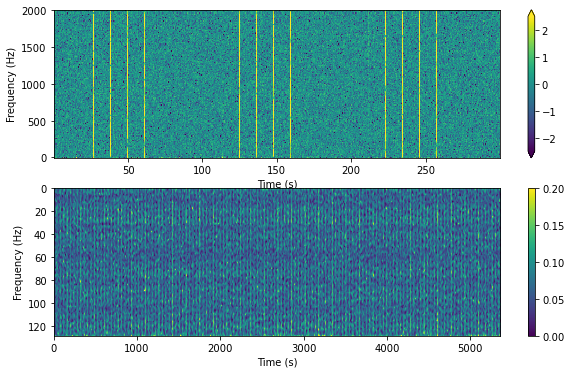

In [128]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
Sx_norm0.plot(ax=ax[0], vmin=-2.5, vmax=2.5)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Frequency (Hz)')

kwargs = {'sigmas': [1], 'mode': 'reflect'}
result = meijering(Sx_norm0, **kwargs)
pos = ax[1].imshow(result, aspect='auto', vmin=0, vmax=0.2)
fig.colorbar(pos,ax=ax[1])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Frequency (Hz)')

There are vertical features occurring every couple of seconds or so. It's a bit hard to see at the resolution of the spectrogram above, but if we zoom in a bit:

Text(0, 0.5, 'Frequency (Hz)')

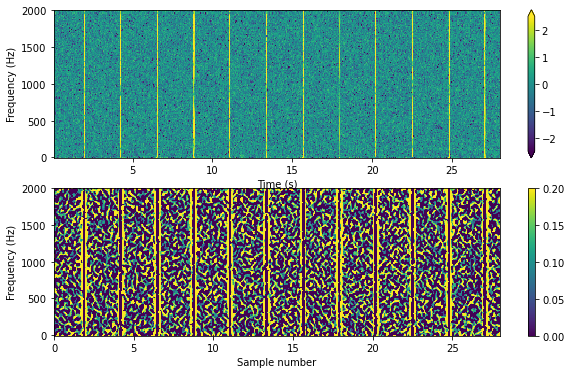

In [129]:
fig, ax = plt.subplots(2,1,figsize=(10,6))
Sx_norm0[:,1:500].plot(ax=ax[0], vmin=-2.5, vmax=2.5)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Frequency (Hz)')

kwargs = {'sigmas': [1], 'mode': 'reflect'}
result = meijering(Sx_norm0[:,1:500], **kwargs)
fvec = Sx_norm0.coords['frequency']
tvec = np.linspace(0,np.max(Sx_norm0.coords['time'][1:500]),np.shape(result)[1])
pos = ax[1].pcolormesh(tvec, fvec,result, vmin=0, vmax=0.2, shading='auto')
fig.colorbar(pos,ax=ax[1])
ax[1].set_xlabel('Sample number')
ax[1].set_ylabel('Frequency (Hz)')

One option to handle this would be to assume that any short-duration, broadband signals like this are some sort of electrical or mechanical noise, and just remove them the same way we detrended over frequency. 

Text(0, 0.5, 'Frequency (Hz)')

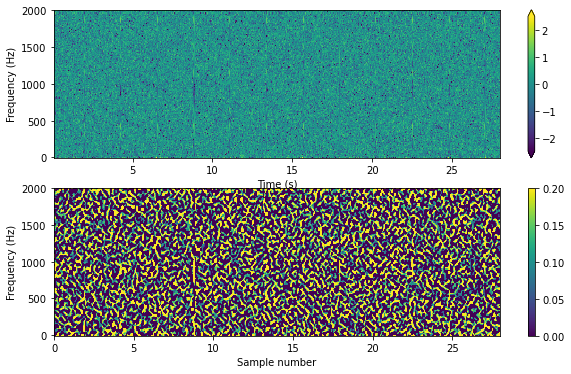

In [130]:
# Detrend over axis = 0
Sx_norm = Sx_norm0 - Sx_norm0.mean(axis=0)

# 
fig, ax = plt.subplots(2,1,figsize=(10,6))
Sx_norm[:,1:500].plot(ax=ax[0], vmin=-2.5, vmax=2.5)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Frequency (Hz)')

kwargs = {'sigmas': [1], 'mode': 'reflect'}
result = meijering(Sx_norm[:,1:500], **kwargs)
fvec = Sx_norm.coords['frequency']
tvec = np.linspace(0,np.max(Sx_norm.coords['time'][1:500]),np.shape(result)[1])
pos = ax[1].pcolormesh(tvec, fvec,result, vmin=0, vmax=0.2, shading='auto')
fig.colorbar(pos,ax=ax[1])
ax[1].set_xlabel('Sample number')
ax[1].set_ylabel('Frequency (Hz)')

The blips are gone! The problem with this method is that sometimes short-duration, broadband sounds like this are actually biological in origin. A good example of this would be sperm whale clicks. If we do normalization in this way, we will probably accidentally average out some of the signals we might be interested in. 

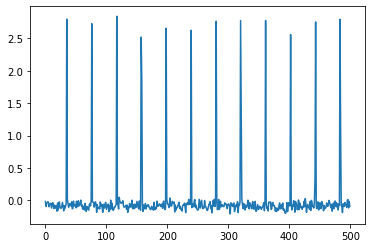

In [131]:
plt.plot(Sx_norm0.mean(axis=0)[0:500],'-')